In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from multiprocessing import Pool
import os

In [4]:
from src.ingestion import *
from src.baseline import *
from src.matrix import *
from src.model import *

### Data Ingestion

We want to get urls for 300 benign apps. Since some apps are unable to be downloaded automatically with code, I put in a slightly higher number, 18 apps for each of 20 randomly selected categories of apps, to be download so we get sufficient apps, resulting in 314 benign apps. Then we download it to outpath `data`, and clean the app folder.

In [14]:
benign_urls = get_app_urls("https://apkpure.com/sitemap.xml",20,18)

In [13]:
download_apk(benign_urls, 'data', 'analysis')

In [16]:
clean_disk('data')

### EDA

We then get paths from downloaded files, as well as malwares provided, and turn then into strings.

In [4]:
benign_paths = get_benign_paths('data', cat='analysis')
malware_paths = get_malware_paths('/datasets/dsc180a-wi20-public/Malware/amd_data_smali', 300)

In [5]:
with open('benign_paths.txt', 'w') as f:
    for item in benign_paths:
        f.write("%s\n" % item)
with open('malware_paths.txt', 'w') as f:
    for item in malware_paths:
        f.write("%s\n" % item)

In [5]:
with open('benign_paths.txt') as f:
    benign_paths = f.read().splitlines()

In [6]:
with open('malware_paths.txt') as f:
    malware_paths = f.read().splitlines()

In [7]:
def process_smali(p):
    return smalis_from_paths(get_smali_paths(p))

In [7]:
pool = Pool(os.cpu_count())                 
benign_smalis = pool.map(process_smali, benign_paths)
pool.close()

In [8]:
pool = Pool(os.cpu_count())                 
malware_smalis = pool.map(process_smali, malware_paths)
pool.close()

In [9]:
smalis, y = get_Xy(benign_smalis, malware_smalis)

In [5]:
with open('y.txt') as f:
    y = f.read().splitlines()

In [6]:
smalis = pd.read_csv('smalis.csv')

In [10]:
smalis.to_csv('smalis.csv', index = False)

In [15]:
apis = smalis.apply(smali2apis, axis = 1)

Then we perform some EDA.

In [16]:
A, classes = construct_A(apis)

In [21]:
api_count = pd.DataFrame(A.todense(), columns = classes).sum().to_frame()
print('Number of API calls that only appear once: '+str(len(api_count[api_count[0]==1])))
print('Number of API calls that are most common: '+str(len(api_count[api_count[0]>280])))

Number of API calls that only appear once: 1184938
Number of API calls that are most common: 1468


In [26]:
def process_feat(app):
    """
    given smali files of an app, return its basic features
    
    Args:
        app - series of smali files of an app
        
    """
        na, ua, nb, ub, mp = basic_stats(app)
        return [na, ua, nb, ub, mp]
    
def extract_simple_feat(smalis, y, y_col = 'malware'):
    """
    given a dataframe of smali files of apps, output dataframe of the simple features of app
    
    Args:
        smalis - dataframe of smali files, in which each row is an app
        y - the label of this set of apps
        y_col - the column name for label, default malware
        
    """
    num_apis = []
    unique_apis = []
    num_methods = []
    unique_methods = []
    most_used_package = []
    
        
    pool = Pool(os.cpu_count())                 
    mat = pool.map(process_feat, smalis)
    pool.close()
        
    df = pd.DataFrame(mat, columns = ['num_api', 'unique_api', 'num_method', 'unique_method', 'most_used_package'])
    df[y_col] = y
    return df

In [27]:
df_benign = extract_simple_feat(benign_smalis, 0)
df_malware = extract_simple_feat(malware_smalis, 1)
df = pd.concat([df_benign, df_malware])

In [28]:
df.to_csv('simple_feat.csv', index = False)

For 100 apps we downloaded/accesses, only 85 are meaningful.

In [29]:
df_wona = df[df['num_api']!=0]
df_wona.describe()

,num_api,unique_api,num_method,unique_method,malware
count,572.000000,572.000000,572.000000,572.000000,572.000000
mean,76220.846154,14465.318182,22037.171329,20908.375874,0.524476
std,69200.974793,13015.477347,20710.641929,19595.765069,0.499838
min,8.000000,2.000000,9.000000,9.000000,0.000000
25%,12030.500000,2260.000000,2258.500000,2169.000000,0.000000
50%,50189.500000,8981.500000,12838.500000,12275.500000,1.000000
75%,144134.000000,27486.000000,43236.750000,40923.000000,1.000000
max,360551.000000,38282.000000,59050.000000,54665.000000,1.000000


We generate some plots to help us visualize the distribution of numbers.

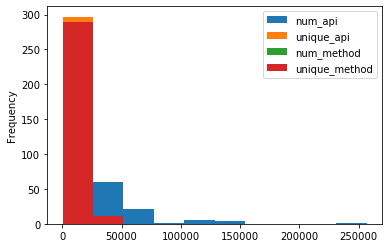

In [32]:
df_wona[df_wona['malware']==1].drop('malware',1).plot.hist()

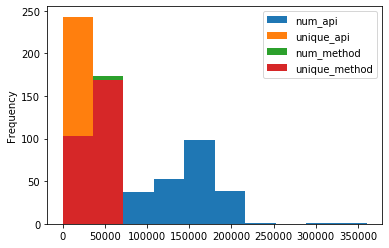

In [31]:
df_wona[df_wona['malware']==0].drop('malware',1).plot.hist()

In [33]:
df_wona.most_used_package.value_counts()

Ljava/lang/StringBuilder;                                                    490
Landroid/os/Parcel;                                                           53
Ljava/lang/StringBuffer;                                                      11
Ljava/lang/String;                                                             4
Ljava/lang/RuntimeException;                                                   3
LA001;                                                                         2
Landroid/widget/ImageView;                                                     2
Lio/hansel/pebbletracesdk/codepatch/PatchJoinPoint$PatchJoinPointBuilder;      1
Lshd/nsnamtwl/nlogllb/wvvoqnwbrwtbg2_nh/cGame;                                 1
Lcom/bs/dtu/kangyosukui/c;                                                     1
Lcom/ubisoft/videoplayer/MediaPlayerListener;                                  1
Lmmq/ttawlmlp/jsadbia/eif2/cGame;                                              1
Lg;                         

### Baseline

We will be using above features to feed in logistic regression, random forest, and gradient boost classifier as our baseline models.

In [34]:
X = df_wona.drop('malware', 1)
y = df_wona.malware

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [36]:
pre = preprocess(X_train)

In [37]:
df_train = X_train.assign(malware = y_train)
df_test = X_test.assign(malware= y_test)

In [38]:
result_lr = result_LR(df_train, df_test, pre)
lr = compute_metrics(list(result_lr))

In [39]:
result_rf = result_RF(df_train, df_test, pre)
rf = compute_metrics(list(result_rf))

In [40]:
result_gbt = result_GBT(df_train, df_test, pre)
gbt = compute_metrics(list(result_gbt))

In [41]:
baseline_result = pd.DataFrame([lr, rf, gbt], columns=['tn', 'fp', 'fn', 'tp', 'acc', 'fnr'], index = np.array(['logistic regression', 'random forest', 'gradient boost']))

In [42]:
baseline_result

,tn,fp,fn,tp,acc,fnr
logistic regression,77,17,3,92,0.894180,0.031579
random forest,82,12,3,92,0.920635,0.031579
gradient boost,80,14,3,92,0.910053,0.031579


As we can observe above, our baseline models actually perform really well on small amount of data.

### Matrix

We will start constructing our matrices and kernels.

In [12]:
len(y)

615

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(smalis, y, test_size=0.33, shuffle=True)

In [11]:
from multiprocessing import Process, Queue, Manager

def get_APA_test(app_smalis, test_app_smalis):
    smalis = pd.DataFrame(app_smalis)
    apis = smalis.apply(smali2apis, axis = 1)
    print('constructing A...')
    A, all_apis = construct_A(apis)
    print('finish A construction')
    test_smalis = pd.DataFrame(test_app_smalis)
    test_apis = test_smalis.apply(smali2apis, axis = 1)
    print('constructing A_test...')
    A_test = construct_A_test(test_apis, all_apis)
    print('finish A_test construction')

    print('constructing P...')
    P = construct_P(all_apis)
    print('finish p construction')
    return A, A_test, P

def get_B(smalis):
    print('constructing B...')
    B = construct_B(smalis)
    print('finish B construction')
    return B

def method1(app_smalis, test_app_smalis, l1):
  
    l1.put(get_APA_test(app_smalis, test_app_smalis))
    

def method2(smalis, l2):

    l2.put(get_B(smalis))

In [14]:
import multiprocessing

def worker(api, apis, return_dict):
    '''worker function'''
    if api not in return_dict.keys():
        return_dict[api] = apis
    else:
        return_dict[api] = return_dict[api].union(apis)


In [15]:
def construct_B(smalis):
    """
    construct B matrix

    Args:
        smalis - dataframe of smali files
        
    """
    manager = Manager()
    B_dict = manager.dict()
            
    blocks = smalis.apply(smali2blocks, axis = 1).explode() #get a series of blocks
    jobs = []
    print('start for loop')
    for block in blocks:
        apis = set(re.findall('invoke-\w+ {.*}, (.*?)\\(', block))
        for api in apis:
            p = Process(target=worker, args=(api, apis, B_dict))
            jobs.append(p)
            p.start()
    print('finish for loop')
    for proc in jobs:
        proc.join()
    mlb = MultiLabelBinarizer(sparse_output = True)
    return mlb.fit_transform(B_dict.values())

In [ ]:
B = construct_B(X_train)

start for loop


In [22]:
l1 = Queue()
p1 = Process(target=method1, args=(X_train, X_test, l1, ))
l2 = Queue()
p2 = Process(target=method2, args=(X_train, l2, ))
p1.start()
p2.start()
A, A_test, P = l1.get()          
B = l2.get()

constructing B...
constructing A...
finish A construction
constructing A_test...
finish A_test construction
constructing P...
finish p construction


KeyboardInterrupt: 

Process Process-86:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-21-ac1fda131fe3>", line 33, in method2
    l2.put(get_B(smalis))
  File "<ipython-input-21-ac1fda131fe3>", line 22, in get_B
    B = construct_B(smalis)
  File "/datasets/home/home-02/58/458/yuc330/hindroid_replication/src/matrix.py", line 123, in construct_B
    blocks.dropna().apply(block2apis) #update B_dict
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/series.py", line 4038, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas/_libs/lib.pyx", line 2227, in pandas._libs.lib.map_infer
  File "/datasets/home/home-02/58/458/yuc330/hindroid_replication/src/matrix.py", line 120, in block2apis
    B_dict[api] = B_dict[api].union(apis)
KeyboardInte

<1377261x1377261 sparse matrix of type '<class 'numpy.int64'>'
	with 29857303 stored elements in Compressed Sparse Row format>

In [ ]:
A, A_test, B, P = construct_matrices(X_train, X_test)

In [ ]:
save_matrix_to_file(A, 'output/A_analysis.npz') #save matrices to file
save_matrix_to_file(B, 'output/B_analysis.npz')
save_matrix_to_file(P, 'output/P_analysis.npz')
save_matrix_to_file(A_test, 'output/A_test_analysis.npz')

In [13]:
kernels_train = construct_kernel_train(A, B, P)
kernels_test = construct_kernel_test(A, A_test, B, P)

In [ ]:
train = []
test = []
for i in range(4):
    d = train_test_svm(kernels_train[i].todense(), kernels_test[i].todense(), y_train, y_test)
    train.append(d['train'])
    test.append(d['test'])
train_df = pd.DataFrame(train, columns=['tn', 'fp', 'fn', 'tp', 'acc', 'fnr'], index = np.array(['AA^t', 'ABA^t', 'APA^t', 'APBP^tA^t']))
test_df = pd.DataFrame(test, columns=['tn', 'fp', 'fn', 'tp', 'acc', 'fnr'], index = np.array(['AA^t', 'ABA^t', 'APA^t', 'APBP^tA^t']))

In [ ]:
train_df

In [ ]:
test_df

In [38]:
d = train_test_svm(A.dot(A.T).todense(), A_test.dot(A.T).todense(), y_train, y_test)

In [39]:
d

{'train': [204, 0, 0, 208, 1.0, 0.0],
 'test': [103, 8, 1, 91, 0.9556650246305419, 0.010869565217391304]}